# Content Based 3d Model Retrieval

### Convolutional Neural Networks on 3D models
http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

We will be learning on 3D images that are made up of voxels. Simply think pixels, but for 3D.

```
To study 3D shape representation, we propose to represent
a geometric 3D shape as a probability distribution of
binary variables on a 3D voxel grid. Each 3D mesh is represented
as a binary tensor: 1 indicates the voxel is inside the
mesh surface, and 0 indicates the voxel is outside the mesh
(i.e., it is empty space). The grid size in our experiments is
30 × 30 × 30.
```

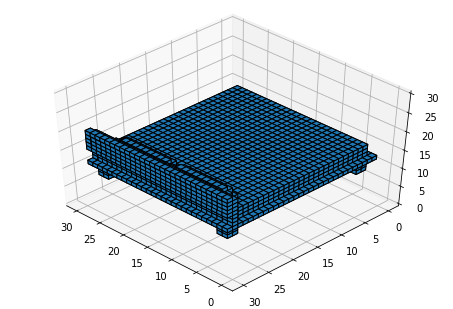

This is a bed.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from data import load_data
from plots import plot_vox

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')

plot_vox(x_train[0].reshape(30, 30, 30)), \
print("This is a {}.".format(target_names[y_train[0]]));

## Evaluate class balance for ModelNet10 and ModelNet40

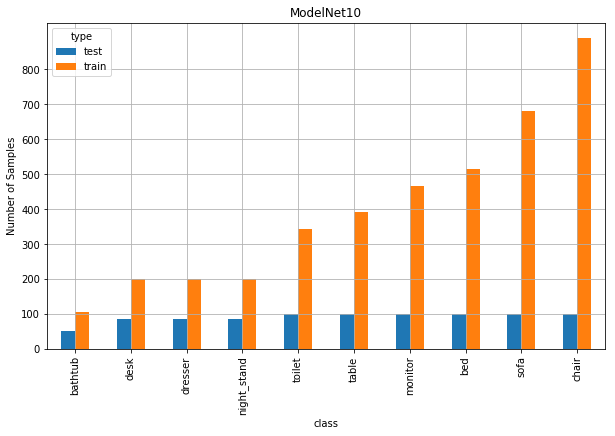

type         test  train
class                   
bathtub        50    106
desk           86    200
dresser        86    200
night_stand    86    200
toilet        100    344
table         100    392
monitor       100    465
bed           100    515
sofa          100    680
chair         100    889

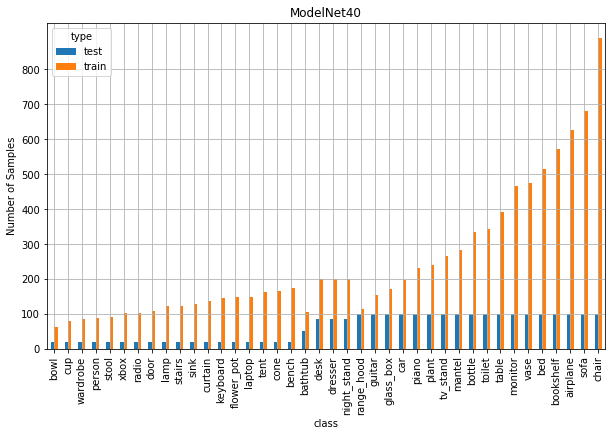

type         test  train
class                   
bowl           20     64
cup            20     79
wardrobe       20     87
person         20     88
stool          20     90
xbox           20    103
radio          20    104
door           20    109
lamp           20    124
stairs         20    124
sink           20    128
curtain        20    138
keyboard       20    145
flower_pot     20    149
laptop         20    149
tent           20    163
cone           20    167
bench          20    173
bathtub        50    106
desk           86    200
dresser        86    200
night_stand    86    200
range_hood    100    115
guitar        100    155
glass_box     100    171
car           100    197
piano         100    231
plant         100    240
tv_stand      100    267
mantel        100    284
bottle        100    335
toilet        100    344
table         100    392
monitor       100    465
vase          100    475
bed           100    515
bookshelf     100    572
airplane      100    626
sofa          100    680
chair         100    889

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from count_files import (make_file_description_data_frame,
                         plot_unbalanced_classes)

df = make_file_description_data_frame('./ModelNet10/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet10')

df = make_file_description_data_frame('./ModelNet40/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet40')

### Class Balance

class to class imbalance is dealt with using upsampling on **only the training data**

train to val imbalance is dealt with using stratified sampling

The plots below verify that we have in fact successfully balanced the classes. Please look in the plots module if you'd like to see specifically what is going on to accomplish this.

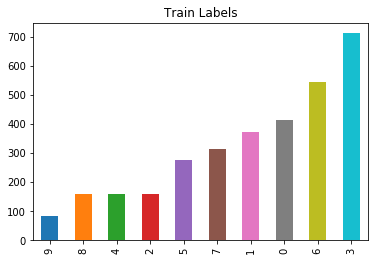

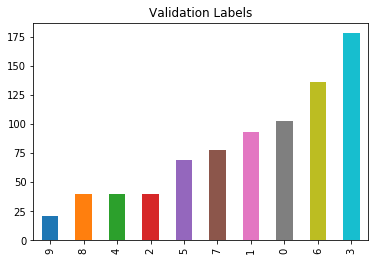

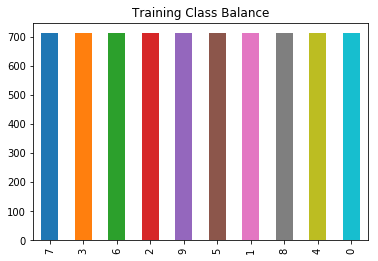

In [1]:
from plots import plot_class_balance
%matplotlib inline

plot_class_balance()

### Build Model
as found in 3DShapeNets paper

In [5]:
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from data import load_data
from plots import plot_vox
from utils import upsample_classes, stratified_shuffle

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
x_train, y_train, x_val, y_val = stratified_shuffle(x_train, y_train, test_size=.1)
x_train, y_train = upsample_classes(x_train, y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop


model = Sequential()
model.add(Conv3D(48, 6, strides=2,
                 padding='same',
                 activation='relu',
                 input_shape=(30, 30, 30, 1)))
model.add(Conv3D(160, 5, strides=2,
                 padding='same',
                 activation='relu'))
model.add(Conv3D(512, 4, strides=1,
                 padding='same'))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='softmax'))




optimizer = SGD(lr=0.01, momentum=.7, decay=1e-5, nesterov=True)
model.summary()
model.compile(optimizer,
              'categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 15, 15, 48)    10416     
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 8, 8, 160)      960160    
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 8, 8, 512)      5243392   
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1200)              314574000 
_________________________________________________________________
dropout_3 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              4804000   
__________

In [20]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(x_train, y_train,
          epochs=10,
          batch_size=100,
          shuffle=True,
          validation_data=(x_val, y_val),
          callbacks=[TensorBoard(log_dir='./tensor_board.log'), checkpointer])

model.evaluate(x_test, y_test)

Train on 8000 samples, validate on 400 samples
Epoch 1/10
8000/8000 [==============================] - 30s 4ms/step - loss: 1.1087 - acc: 0.6473 - val_loss: 0.3524 - val_acc: 0.8875

Epoch 00001: val_loss improved from inf to 0.35236, saving model to weights.best.hdf5
Epoch 2/10
8000/8000 [==============================] - 20s 3ms/step - loss: 0.2834 - acc: 0.9053 - val_loss: 0.3029 - val_acc: 0.9075

Epoch 00002: val_loss improved from 0.35236 to 0.30291, saving model to weights.best.hdf5
Epoch 3/10
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1873 - acc: 0.9378 - val_loss: 0.3063 - val_acc: 0.9175

Epoch 00003: val_loss did not improve
Epoch 4/10
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1476 - acc: 0.9484 - val_loss: 0.3374 - val_acc: 0.9150

Epoch 00004: val_loss did not improve
Epoch 5/10
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1127 - acc: 0.9573 - val_loss: 0.3250 - val_acc: 0.9175

Epoch 00005: val_loss

[0.5920850709080696, 0.8667400881057269]

In [7]:
model.evaluate(x_test, y_test)

908/908 [==============================] - 1s 942us/step


[0.4986807402558748, 0.8204845814977973]

### Accuracy on Test set ~82%

In [6]:
model.load_weights('./weights.best.hdf5')

# Where CNN is affected by rotation

CNNs aren't pose invariant. See the plots below

Normal vs Rotated by -90 on (1, 2) axes


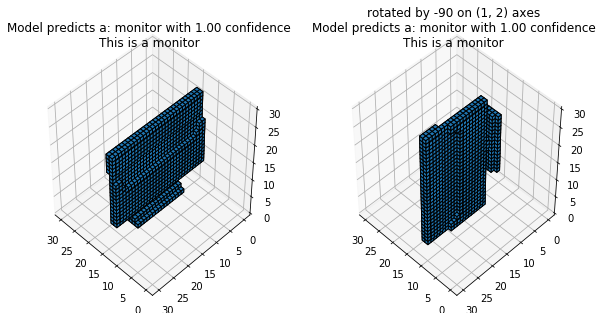

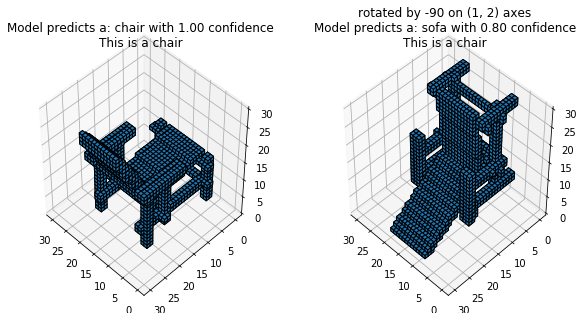

Normal vs Rotated by 90 on (1, 2) axes


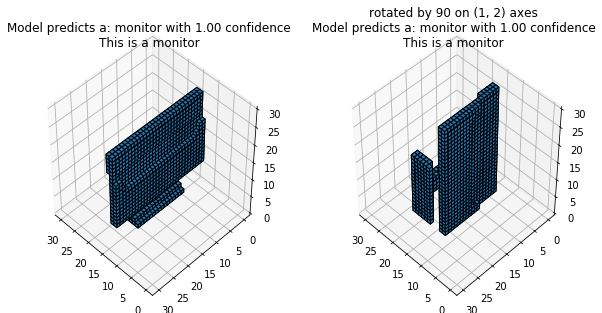

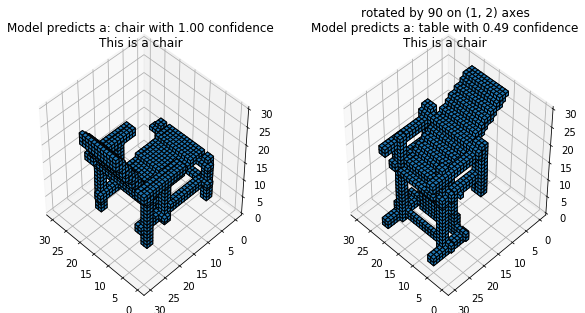

Normal vs Rotated by -90 on (0, 1) axes


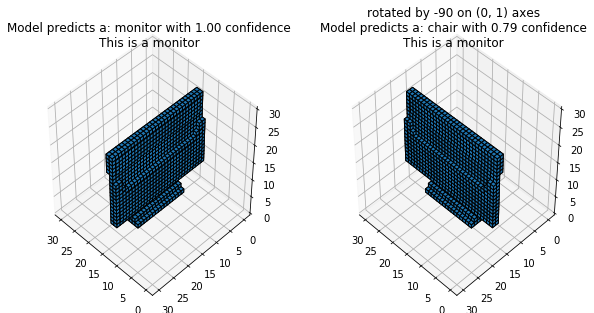

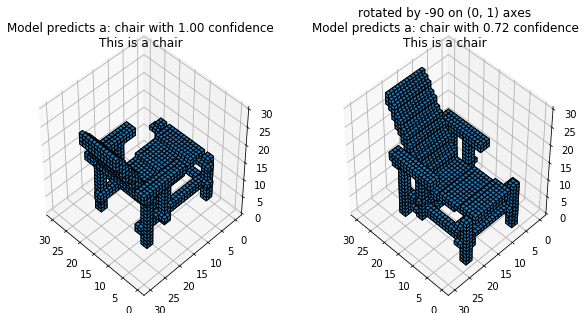

Normal vs Rotated by 90 on (0, 1) axes


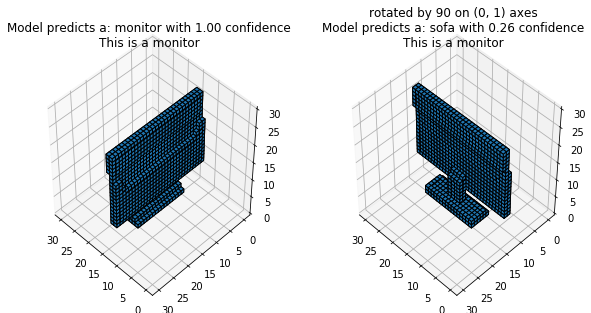

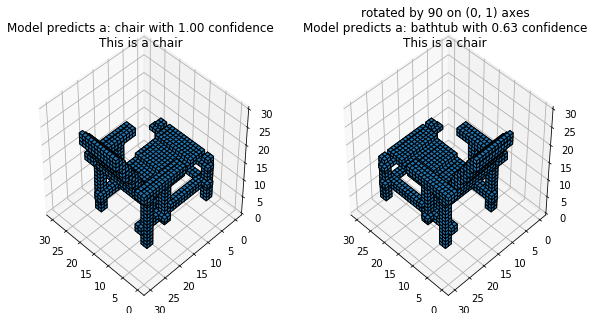

Normal vs Rotated by -90 on (0, 2) axes


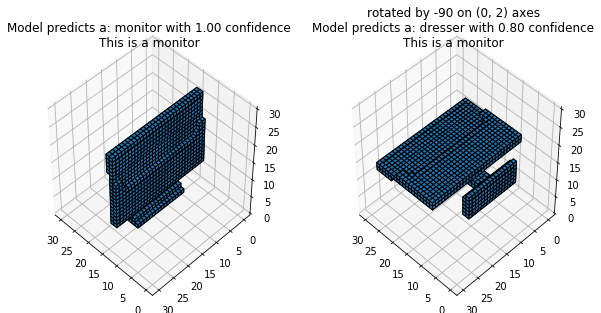

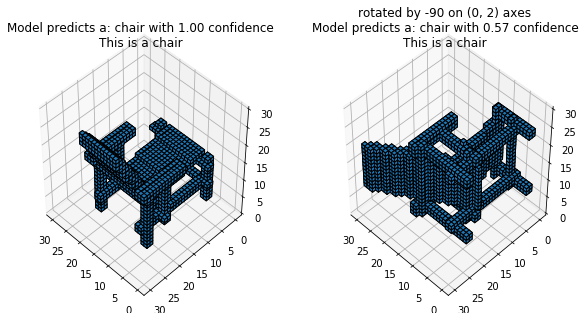

Normal vs Rotated by 90 on (0, 2) axes


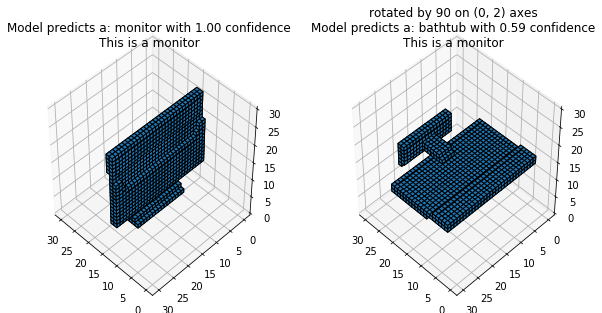

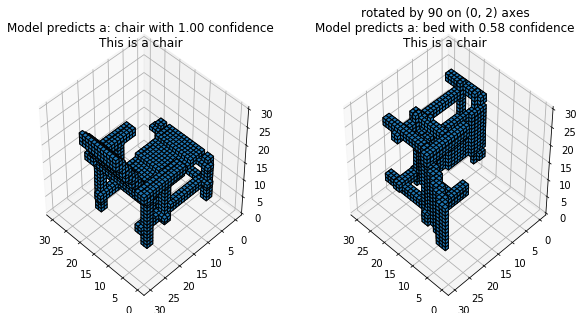

In [14]:
from plots import plot_rotation_issue
poses = [
    (-90, (1, 2)),
    (90, (1, 2)),
    (-90, (0, 1)),
    (90, (0, 1)),
    (-90, (0, 2)),
    (90, (0, 2))
]
for rot, axes in poses:
    print('Normal vs Rotated by {} on {} axes'.format(rot, axes))
    plot_rotation_issue(x_test[100:101], y_test[100],
                        target_names, model, rot, axes)
    plot_rotation_issue(x_test[300:301], y_test[300],
                        target_names, model, rot, axes)

You can see that the monitor does ok for axes that keep the majority of the monitor's 'flatness' within the same bounds as the normal model. But, as soon as you rotate it in an axis that pulls the monitor out of the largest bound (the direction when you tip it down onto its face) you see the confidence go way down. 

The same is true for the chair. The chair isn't really necessary in order to see what's happening, but it seems prudent to include it so we know this isn't singular to the monitor model. 

### Time to actually try out Capsule Nets

Now that we've shown that CNNs aren't pose invariant, it's now time to do what we've all been waiting for... IMPLEMENT Capsule Nets!

In [1]:
import numpy as np
# from keras import layers, models, optimizers
from keras.datasets import mnist
from keras.layers import Conv3D, Dense, Reshape, Add, Input
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image

from utils import combine_images
from capsulenet import margin_loss
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

from data import load_data
from plots import plot_vox
from utils import upsample_classes, stratified_shuffle

/Users/ryan/repos/3d_model_retriever/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
x_train, y_train, x_val, y_val = stratified_shuffle(x_train, y_train, test_size=.1)
x_train, y_train = upsample_classes(x_train, y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [3]:
x_train = x_train[:100]
y_train = y_train[:100]

In [4]:
n_class = y_test.shape[1]
input_shape = (30, 30, 30, 1)

In [5]:
x = Input(shape=(30, 30, 30, 1))


conv1 = Conv3D(filters=48, kernel_size=9, strides=1,
               padding='valid', activation='relu', name='conv1')(x)


primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32,
                         kernel_size=9, strides=2, padding='valid')


digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16,
                         routings=3, name='digitcaps')(primarycaps)


out_caps = Length(name='capsnet')(digitcaps)


y = Input(shape=(n_class,))
masked_by_y = Mask()([digitcaps, y])

masked = Mask()(digitcaps)

decoder = Sequential(name='decoder')
decoder.add(Dense(512, activation='relu',
                  input_dim=16*n_class))
decoder.add(Dense(1024, activation='relu'))
decoder.add(Dense(np.prod(input_shape), activation='sigmoid'))

decoder.add(Reshape(target_shape=input_shape, name='out_recon'))

train_model = Model([x, y], [out_caps, decoder(masked_by_y)])


eval_model = Model(x, [out_caps, decoder(masked)])



### manipulate model
noise = Input(shape=(n_class, 16))
noised_digitcaps = Add()([digitcaps, noise])
masked_noised_y = Mask()([noised_digitcaps, y])
manipulate_model = Model([x, y, noise], decoder(masked_noised_y))

Instructions for updating:
dim is deprecated, use axis instead


In [6]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 30, 30, 1 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 22, 22, 22, 4 35040       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv3d (Conv3D)      (None, 7, 7, 7, 256) 8958208     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 10976, 8)     0           primarycap_conv3d[0][0]          
__________________________________________________________________________________________________
primarycap

In [8]:
# optimizer = SGD(lr=0.001, momentum=.7, decay=1e-5, nesterov=True)
optimizer = Adam(lr=0.001)
train_model.compile(optimizer,
                    loss=[margin_loss, 'mse'],
                    loss_weights=[1., .392],
                    metrics={'capsnet': 'accuracy'})

In [8]:
from keras.callbacks import TensorBoard, ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='capsnets.weights.best.hdf5',
                               verbose=1, save_best_only=True)

In [ ]:
train_model.fit([x_train, y_train], [y_train, x_train],
                batch_size=32, epochs=1,
                validation_data=[[x_val, y_val], [y_val, x_val]],
                callbacks=[checkpointer])

Train on 100 samples, validate on 399 samples
Epoch 1/1


In [ ]:
model = Sequential()
model.add(Conv3D(48, 6, strides=2,
                 padding='same',
                 activation='relu',
                 input_shape=(30, 30, 30, 1)))
model.add(Conv3D(160, 5, strides=2,
                 padding='same',
                 activation='relu'))
model.add(Conv3D(512, 4, strides=1,
                 padding='same'))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='softmax')

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(x_train, y_train,
          epochs=10,
          batch_size=100,
          shuffle=True,
          validation_data=(x_val, y_val),
          callbacks=[TensorBoard(log_dir='./tensor_board.log'), checkpointer])

# Appendix

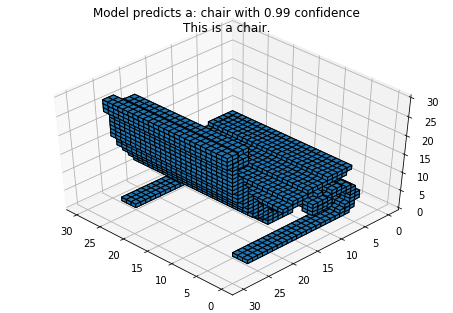

In [28]:
from plots import plot_vox

def plot_model_guess(num):
    truth = target_names[np.argmax(y_test[num])]
    proba = model.predict(x_test[num].reshape(1, 30, 30, 30, 1))
    proba_idx = np.argmax(proba)
    predicted_name = target_names[proba_idx]
    plot_vox(x_test[num].reshape(30, 30, 30),
             title='Model predicts a: {1} with {2:.2f} confidence\nThis is a {0}.'\
              .format(truth, predicted_name, proba[0][proba_idx]))
#     print('this is a {}'.format(target_names[np.argmax(y_test[num])]))
#     proba = model.predict(x_test[num].reshape(1, 30, 30, 30, 1))
#     predicted_name = target_names[np.argmax(proba)]
#     print('the model predicts a {}'.format(predicted_name))

plot_model_guess(350)

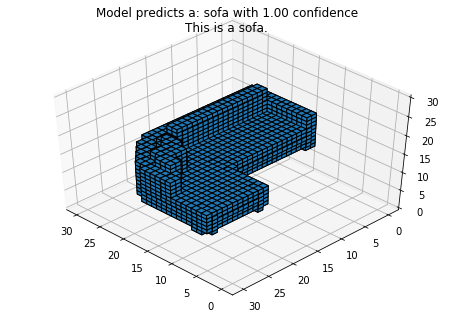

In [29]:
plot_model_guess(0)

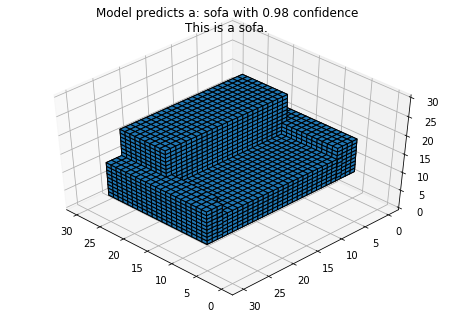

In [30]:
plot_model_guess(80)

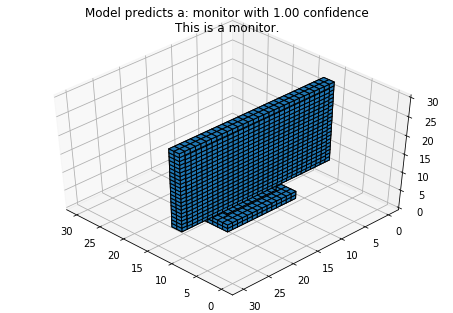

In [31]:
plot_model_guess(160)

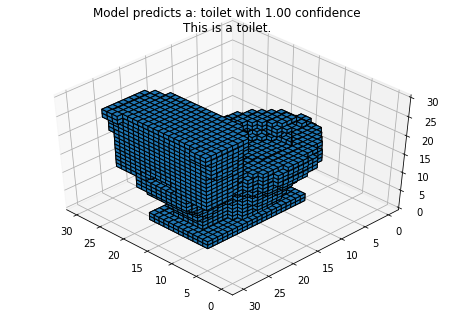

In [32]:
plot_model_guess(240)

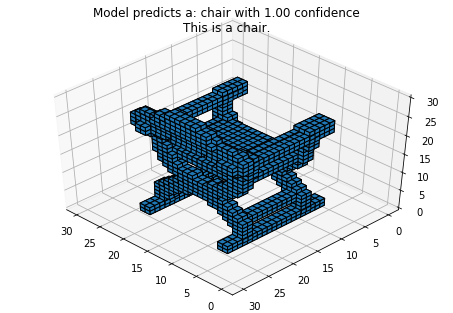

In [33]:
plot_model_guess(320)

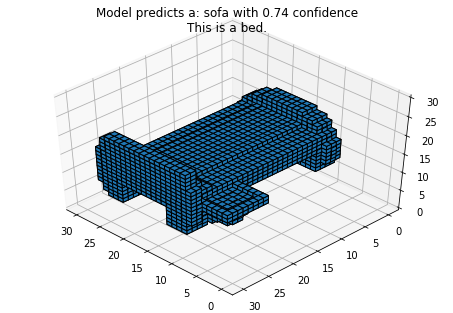

In [34]:
plot_model_guess(400)

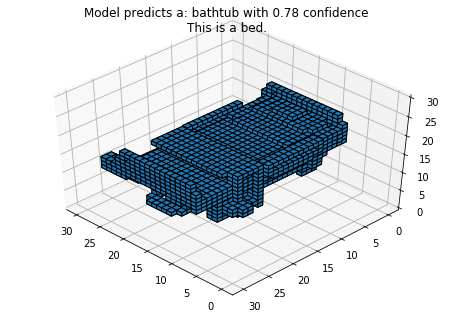

In [35]:
plot_model_guess(480)

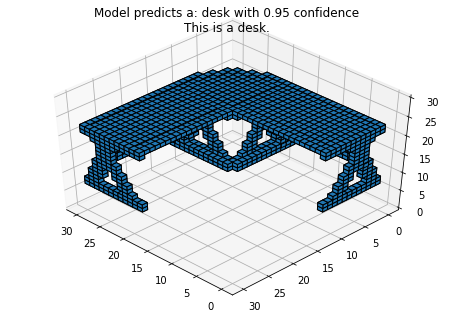

In [36]:
plot_model_guess(560)

WRONG! :-D

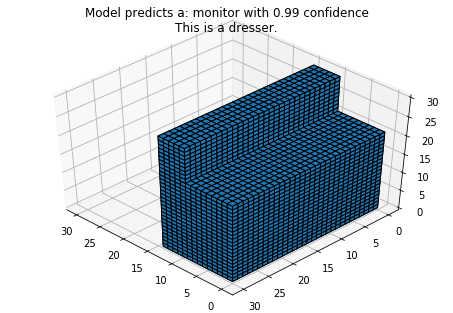

In [37]:
plot_model_guess(640)

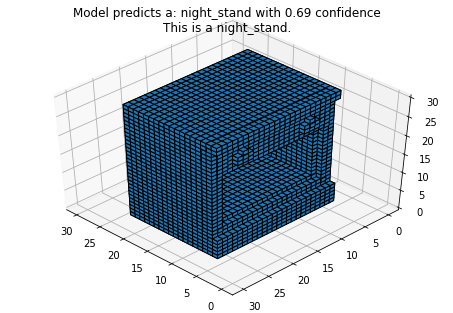

In [38]:
plot_model_guess(720)

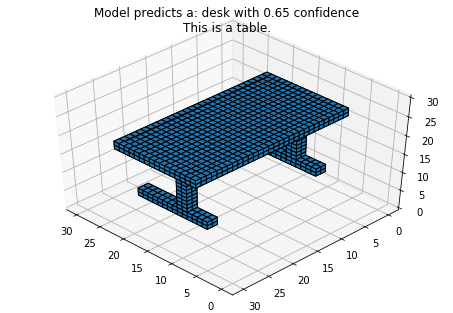

In [39]:
plot_model_guess(800)

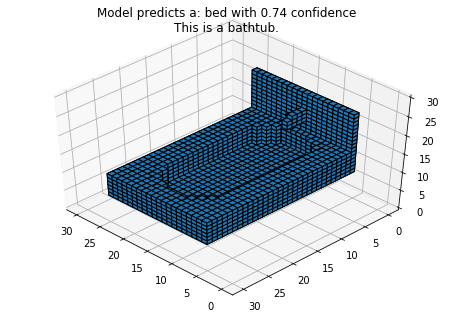

In [41]:
plot_model_guess(880)

# Appendix of fixes:

### Fix rotation issue

In [1]:
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import binvox_rw_py as binvox
import scipy as sp

from data import load_data
from plots import plot_vox
from utils import upsample_classes, stratified_shuffle

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
del x_train, y_train

monitor = x_test[100:101].reshape(30, 30, 30)

/Users/ryan/repos/3d_model_retriever/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


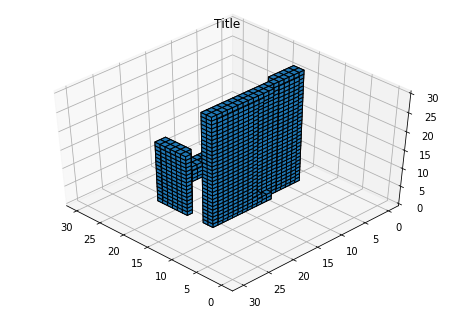

In [4]:
# rotated_monitor = sp.ndimage.interpolation.rotate(monitor, angle=, axes=(1, 0), reshape=False)
rotated_monitor = np.rot90(monitor, 1, axes=(1, 2))
plot_vox(rotated_monitor)

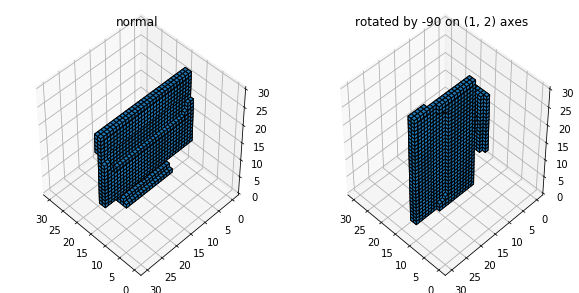

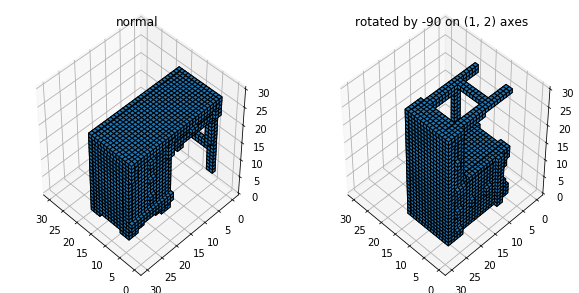

In [2]:
from plots import plot_rotation_issue
poses = [
    (-90, (1, 2)),
]
for rot, axes in poses:
    plot_rotation_issue(x_test[100:101], y_test[100],
                        target_names, angle=rot, axes=axes)
    plot_rotation_issue(x_test[200:201], y_test[200],
                        target_names, angle=rot, axes=axes)

What's up with rotations?